<p style = "font-size : 50px; 
			text-align : center; 
			background-color : #AE6C6C;
			color : #12344c ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<strong>
				Early Chronic Kidney Disease Prediction <br>
				(CKD)
			</strong>
</p>

# Table of contents
1. [Importing Packages](#1)
2. [Importing Data](#2)
3. [Data Cleaning](#3)
   - [Transforming the columns names to more readable names](#3_1)
   - [Analyzing categorical columns.](#3_2)
   - [Replacing NaN values.](#3_3)
4. [Exploratory Data Analysis EDA](#4)
5. [Fix Outliers](#5)
6. [Split the [train/test] data](#6)
7. [Modeling](#7)
   - [Decision Tree](#7_1)
   - [Logistic Regression](#7_2)
   - [Random Forest](#7_3)
   - [XGBoost](#7_4)
8. [Feature Engineering](#8)
9. [Model Evaluation](#9)
10. [Conclusion](#10)

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="1"></a>
			Importing packages
</p>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from tabulate import tabulate
import matplotlib.font_manager as fm

# Data split packages
from collections import Counter
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.preprocessing import StandardScaler

#importing required packages for visualization
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus.graphviz

# Hyperparameter tuning packages
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

# K_Fold Cross Validation packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from statistics import stdev

# Decision Tree packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Logistic Regression package
from sklearn.linear_model import LogisticRegression

#Random Forest Classifier package
from sklearn.ensemble import RandomForestClassifier

#XGBoost package
from xgboost import XGBClassifier

# Feature importance packages
import lime
import lime.lime_tabular


<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="2"></a>
			Importing Data
</p>

In [2]:
df_raw = pd.read_csv("./kidney_disease.csv")

In [3]:
df_raw.shape

(400, 26)

In [4]:
df_raw.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [6]:
# Calculates the percentage of missing values for each column in the "df_raw"

def check_missing_values(df):
	missing_values = []
	for col in df.columns:
		pct_missing = np.mean(df[col].isnull())
		missing_values.append([col, round(pct_missing*100, 2)])
	print(tabulate(missing_values, headers=["Column Name", "Percent Missing"]))

In [7]:
check_missing_values(df_raw)

Column Name       Percent Missing
--------------  -----------------
id                           0
age                          2.25
bp                           3
sg                          11.75
al                          11.5
su                          12.25
rbc                         38
pc                          16.25
pcc                          1
ba                           1
bgr                         11
bu                           4.75
sc                           4.25
sod                         21.75
pot                         22
hemo                        13
pcv                         17.5
wc                          26.25
rc                          32.5
htn                          0.5
dm                           0.5
cad                          0.5
appet                        0.25
pe                           0.25
ane                          0.25
classification               0


**From the previous we can notice that:**
> There are multiple categorical columns in the data set like (pc, pcc, pcv, wc, rc ...etc), we need to change them to binary values.

> There are missing (null) values in the data set, we need to fill them.

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="3"></a>
			Data Cleaning
</p>

<p style = "font-size : 20px; 
			font-family : 'Georgia'; ">
			<a id="3_1"></a>
			1. Transforming the columns names to more readable names.
</p>

In [8]:
# Drop the id column, since it is not relevant for the analysis
# The parameter 'inplace=True' modifies the DataFrame 'df_raw' directly, rather than returning a new modified DataFrame.
df_raw.drop('id', axis=1, inplace=True)

In [9]:
# Change the column names, so that they are more readable

df_raw.columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
				'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
				'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
				'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
				'anemia', 'class']

In [10]:
df_raw.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd


<p style = "font-size : 20px; 
			font-family : 'Georgia'; ">
			<a id="3_2"></a>
			2. Analyzing categorical columns.
</p>

In [11]:
# describe the categorical columns in the DataFrame by:
# first identifying all columns in the DataFrame that have a data type of object, which is often used to represent 
# categorical data.
# Then, for each categorical column, the function prints the column name and the unique values in that column 
# using the unique() method of pandas.

def describe_categorical(df):
	cat_col=[col for col in df.columns if df[col].dtype == 'object']
	for col in cat_col:
		print('{} has {} values '.format(col,df[col].unique()))
		print('\n------------------------------------------------------------')

In [12]:
describe_categorical(df_raw)

red_blood_cells has [nan 'normal' 'abnormal'] values 

------------------------------------------------------------
pus_cell has ['normal' 'abnormal' nan] values 

------------------------------------------------------------
pus_cell_clumps has ['notpresent' 'present' nan] values 

------------------------------------------------------------
bacteria has ['notpresent' 'present' nan] values 

------------------------------------------------------------
packed_cell_volume has ['44' '38' '31' '32' '35' '39' '36' '33' '29' '28' nan '16' '24' '37' '30'
 '34' '40' '45' '27' '48' '\t?' '52' '14' '22' '18' '42' '17' '46' '23'
 '19' '25' '41' '26' '15' '21' '43' '20' '\t43' '47' '9' '49' '50' '53'
 '51' '54'] values 

------------------------------------------------------------
white_blood_cell_count has ['7800' '6000' '7500' '6700' '7300' nan '6900' '9600' '12100' '4500'
 '12200' '11000' '3800' '11400' '5300' '9200' '6200' '8300' '8400' '10300'
 '9800' '9100' '7900' '6400' '8600' '18900' '2160

**From the previous results, we can see that the columns:**

> red_blood_cells, pus_cell, pus_cell_clumps, 'bacteria, 'hypertension, 
	diabetes_mellitus, coronary_artery_disease, appetite, peda_edema, anemia, class

have only two main values, so we can convert them to binary values (1, 0).
Also we can notice that the column:

> packed_cell_volume , white_blood_cell_count, red_blood_cell_count

have values that are not numerical, so we can convert them to numerical values.


**- Converting ['packed_cell_volume' , 'white_blood_cell_count', 'red_blood_cell_count'] to numeric**

In [13]:
# First we will replace (\t) with empty string and then convert the column to numeric,
# to avoid a lot of missing values in the column.
# cause if we have value like (\t43) will be converted to NaN (Not a Number)
# because it cannot be interpreted as a numeric value.

df_raw['packed_cell_volume'] = df_raw['packed_cell_volume'].replace('\t', '', regex=True)
df_raw['white_blood_cell_count'] = df_raw['white_blood_cell_count'].replace('\t', '', regex=True)
df_raw['red_blood_cell_count'] = df_raw['red_blood_cell_count'].replace('\t', '', regex=True)

#-----------------------------------------------------------------------------------------------------
df_raw['packed_cell_volume'] = pd.to_numeric(df_raw['packed_cell_volume'], errors='coerce')
df_raw['white_blood_cell_count'] = pd.to_numeric(df_raw['white_blood_cell_count'], errors='coerce')
df_raw['red_blood_cell_count'] = pd.to_numeric(df_raw['red_blood_cell_count'], errors='coerce')

In [14]:
describe_categorical(df_raw)

red_blood_cells has [nan 'normal' 'abnormal'] values 

------------------------------------------------------------
pus_cell has ['normal' 'abnormal' nan] values 

------------------------------------------------------------
pus_cell_clumps has ['notpresent' 'present' nan] values 

------------------------------------------------------------
bacteria has ['notpresent' 'present' nan] values 

------------------------------------------------------------
hypertension has ['yes' 'no' nan] values 

------------------------------------------------------------
diabetes_mellitus has ['yes' 'no' ' yes' '\tno' '\tyes' nan] values 

------------------------------------------------------------
coronary_artery_disease has ['no' 'yes' '\tno' nan] values 

------------------------------------------------------------
appetite has ['good' 'poor' nan] values 

------------------------------------------------------------
peda_edema has ['no' 'yes' nan] values 

-------------------------------------------

**Converting ['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria', 'hypertension', 'diabetes_mellitus',  'coronary_artery_disease', 'appetite', 'peda_edema', 'anemia', 'class'] to binary.**

First we can notice the following wrong values in the data set:
> **diabetes_mellitus**:
	```
	\tno
	\tyes
	```

> **coronary_artery_disease**:
	```
	\tno
	```

> **class**:
	```
	ckd\t
	```

In [15]:
df_raw['diabetes_mellitus'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)
df_raw['coronary_artery_disease'].replace(to_replace = {'\tno':'no'},inplace=True)
df_raw['class'].replace(to_replace = {'ckd\t':'ckd'},inplace=True)

In [16]:
describe_categorical(df_raw)

red_blood_cells has [nan 'normal' 'abnormal'] values 

------------------------------------------------------------
pus_cell has ['normal' 'abnormal' nan] values 

------------------------------------------------------------
pus_cell_clumps has ['notpresent' 'present' nan] values 

------------------------------------------------------------
bacteria has ['notpresent' 'present' nan] values 

------------------------------------------------------------
hypertension has ['yes' 'no' nan] values 

------------------------------------------------------------
diabetes_mellitus has ['yes' 'no' nan] values 

------------------------------------------------------------
coronary_artery_disease has ['no' 'yes' nan] values 

------------------------------------------------------------
appetite has ['good' 'poor' nan] values 

------------------------------------------------------------
peda_edema has ['no' 'yes' nan] values 

------------------------------------------------------------
anemia has 

In [17]:
df_raw.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


**Before transforming the Cataegorical columns to binaries values, we need to:** 
- save the names of (cataegorical) columns to use theme later when we replace the null values with the (mode).

- Also save the (numeric) columns name to replace the null values with (mean)

In [18]:
# save the names of (cataegorical) columns
cataegorical_cols = [col for col in df_raw.columns if df_raw[col].dtype == 'object']

# save the (numeric) columns names
numeric_cols = [col for col in df_raw.columns if df_raw[col].dtype != 'object']

**Convert all the categorical columns to binary values:**

In [19]:
df_raw['red_blood_cells'].replace({'normal':0,'abnormal':1}, inplace=True)
df_raw['pus_cell'].replace({'normal':0,'abnormal':1}, inplace=True)
df_raw['pus_cell_clumps'].replace({'notpresent':0,'present':1}, inplace=True)
df_raw['bacteria'].replace({'notpresent':0,'present':1}, inplace=True)
df_raw['hypertension'].replace({'no':0,'yes':1}, inplace=True)
df_raw['diabetes_mellitus'].replace({'no':0,'yes':1}, inplace=True)
df_raw['coronary_artery_disease'].replace({'no':0,'yes':1}, inplace=True)
df_raw['appetite'].replace({'good':0,'poor':1}, inplace=True)
df_raw['peda_edema'].replace({'no':0,'yes':1}, inplace=True)
df_raw['anemia'].replace({'no':0,'yes':1}, inplace=True)
df_raw['class'].replace({'ckd':0,'notckd':1}, inplace=True)

In [20]:
df_raw.head(10)

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,NaN,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,0.0,0.0,0.0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,0.0,0.0,0.0,NaN,...,38.0,6000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31.0,7500.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,1.0,1.0,1.0,0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,0
5,60.0,90.0,1.015,3.0,0.0,NaN,NaN,0.0,0.0,74.0,...,39.0,7800.0,4.4,1.0,1.0,0.0,0.0,1.0,0.0,0
6,68.0,70.0,1.010,0.0,0.0,NaN,0.0,0.0,0.0,100.0,...,36.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0
7,24.0,NaN,1.015,2.0,4.0,0.0,1.0,0.0,0.0,410.0,...,44.0,6900.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0
8,52.0,100.0,1.015,3.0,0.0,0.0,1.0,1.0,0.0,138.0,...,33.0,9600.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0
9,53.0,90.0,1.020,2.0,0.0,1.0,1.0,1.0,0.0,70.0,...,29.0,12100.0,3.7,1.0,1.0,0.0,1.0,0.0,1.0,0


In [21]:
# Check there is any categorical column left:

describe_categorical(df_raw)

# Since this function did not print any output, we can conclude that there is no categorical column left.

<p style = "font-size : 20px; 
			font-family : 'Georgia'; ">
			<a id="3_3"></a>
			3. Replacing NaN values.
</p>

Replacing Missing values:
- In cataegorical columns, we will replace the missing values with (mode), to preserves the distribution 
	of the column and does not introduce any new bias into the data.
	
- In numerical columns, we will replace the missing values with (mean).

Before we start replacing the missing values, we will first check how many missing values are there in each column:

In [22]:
check_missing_values(df_raw)

Column Name                Percent Missing
-----------------------  -----------------
age                                   2.25
blood_pressure                        3
specific_gravity                     11.75
albumin                              11.5
sugar                                12.25
red_blood_cells                      38
pus_cell                             16.25
pus_cell_clumps                       1
bacteria                              1
blood_glucose_random                 11
blood_urea                            4.75
serum_creatinine                      4.25
sodium                               21.75
potassium                            22
hemoglobin                           13
packed_cell_volume                   17.75
white_blood_cell_count               26.5
red_blood_cell_count                 32.75
hypertension                          0.5
diabetes_mellitus                     0.5
coronary_artery_disease               0.5
appetite                             

**Replace the missing values in the numeric columns with the (median):**

In [23]:
# Define a function that will fill missing values in a column of a dataframe with the median of the feature.
def num_col_fill(df, feature):
	
	median = df[feature].median()  # calculate the median value of the specified feature

	df[feature] = df[feature].fillna(median)  # replace any empty or NaN values with the median of the feature

	
for col in numeric_cols:
	num_col_fill(df_raw, col)

**Replace the missing values in the categorical columns with the (mode):**

In [24]:
# This is a function called "cat_col_fill" which takes two parameters
# `df`: A Pandas DataFrame object that represents the dataset being worked on
# `feature`: A string denoting the name of the categorical feature in the DataFrame

def cat_col_fill(df, feature):
	# Compute the mode (most frequent value) of the given feature column in the input DataFrame
	mode = df[feature].mode()[0]
	
	# Replace any missing values in the feature column with the mode value calculated above
	df[feature] = df[feature].fillna(mode)



for col in cataegorical_cols:
	cat_col_fill(df_raw, col)

In [25]:
df_raw.head(10)

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,anemia,class
0,48.0,80.0,1.020,1.0,0.0,0.0,0.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,0.0,0.0,0.0,0
1,7.0,50.0,1.020,4.0,0.0,0.0,0.0,0.0,0.0,121.0,...,38.0,6000.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0
2,62.0,80.0,1.010,2.0,3.0,0.0,0.0,0.0,0.0,423.0,...,31.0,7500.0,4.8,0.0,1.0,0.0,1.0,0.0,1.0,0
3,48.0,70.0,1.005,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,1.0,1.0,1.0,0
4,51.0,80.0,1.010,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,0
5,60.0,90.0,1.015,3.0,0.0,0.0,0.0,0.0,0.0,74.0,...,39.0,7800.0,4.4,1.0,1.0,0.0,0.0,1.0,0.0,0
6,68.0,70.0,1.010,0.0,0.0,0.0,0.0,0.0,0.0,100.0,...,36.0,8000.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0
7,24.0,80.0,1.015,2.0,4.0,0.0,1.0,0.0,0.0,410.0,...,44.0,6900.0,5.0,0.0,1.0,0.0,0.0,1.0,0.0,0
8,52.0,100.0,1.015,3.0,0.0,0.0,1.0,1.0,0.0,138.0,...,33.0,9600.0,4.0,1.0,1.0,0.0,0.0,0.0,1.0,0
9,53.0,90.0,1.020,2.0,0.0,1.0,1.0,1.0,0.0,70.0,...,29.0,12100.0,3.7,1.0,1.0,0.0,1.0,0.0,1.0,0


In [26]:
check_missing_values(df_raw)

Column Name                Percent Missing
-----------------------  -----------------
age                                      0
blood_pressure                           0
specific_gravity                         0
albumin                                  0
sugar                                    0
red_blood_cells                          0
pus_cell                                 0
pus_cell_clumps                          0
bacteria                                 0
blood_glucose_random                     0
blood_urea                               0
serum_creatinine                         0
sodium                                   0
potassium                                0
hemoglobin                               0
packed_cell_volume                       0
white_blood_cell_count                   0
red_blood_cell_count                     0
hypertension                             0
diabetes_mellitus                        0
coronary_artery_disease                  0
appetite   

**Now we can see that there are no missing values in the data set.**

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="4"></a>
			Exploratory Data Analysis<br>EDA
</p>

**Heat Map**

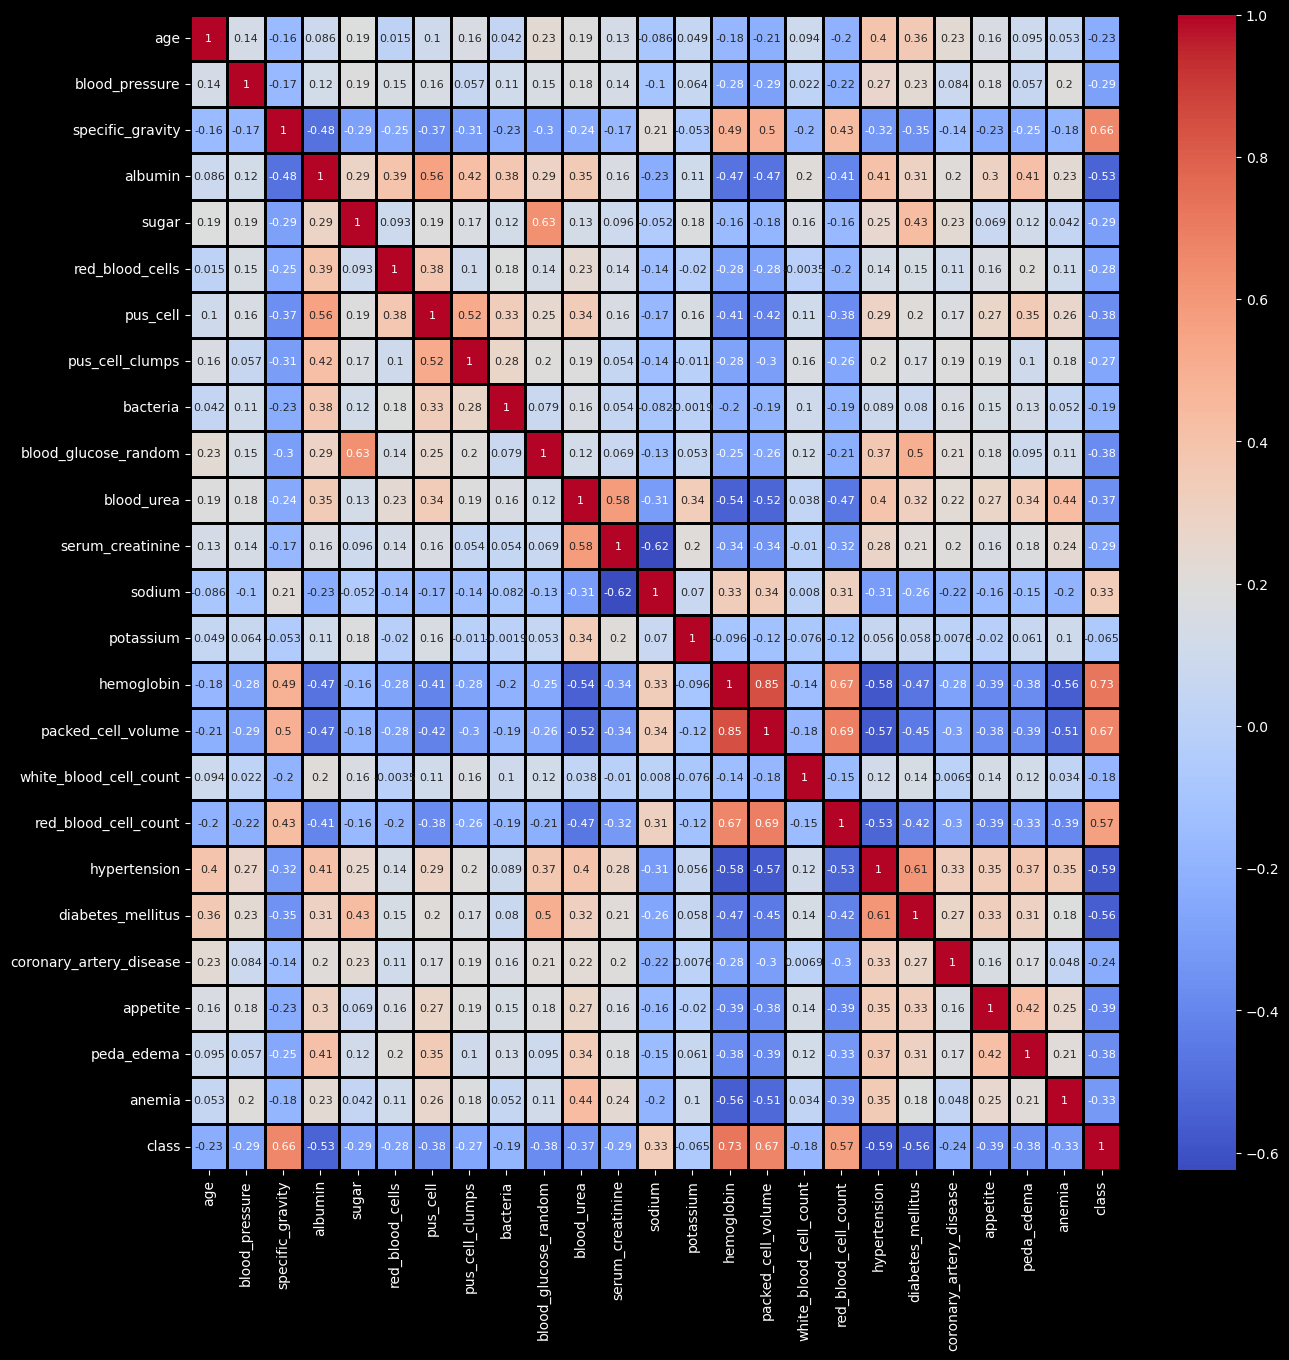

In [27]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_raw.corr(), annot=True, linewidths=1, linecolor='black', cmap='coolwarm', annot_kws={"fontsize":8})
plt.show()

The colors in a heatmap generally indicate the strength and direction of the relationship between two variables. 
Typically:
> - warmer colors (such as red or orange) indicate a positive correlation, meaning that as one variable increases, 
	the other variable tends to increase as well. 

> - Cooler colors (such as blue or green) indicate a negative correlation, meaning that as one variable increases, 
	the other variable tends to decrease.

In our heatmap, the darker the color, the stronger the correlation between the two variables.
we can read the heatmap by looking at the intersection of two variables and examining the color.

For example:

> - if we look at the intersection of "blood_glucose_random" and "sugar," we can see that the color is quite dark, 
	indicating a strong positive correlation between age and blood pressure.

--------------------
**Box Plot**

In [28]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
	fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,14), dpi=300, gridspec_kw={'top': 0.85})
	fig.suptitle(suptitle, y=0.95, size=25, fontweight='bold', fontfamily='serif')
	axs = axs.flatten()

	# Define a color palette
	colors = sns.color_palette("Set2")

	# Set font properties
	font_props = fm.FontProperties(size=9, weight='medium', family='monospace')

	for i, data in enumerate(columns_list):
		sns.boxplot(data=dataset[data], orient='h', ax=axs[i], color=colors[i%len(colors)])
		axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)),
						 fontproperties=font_props)
		xlabel = axs[i].set_xlabel('Values', fontproperties=font_props)
		ylabel = axs[i].set_ylabel('', fontproperties=font_props)

		# Move x-axis label down
		xlabel_pos = xlabel.get_position()
		xlabel.set_position((xlabel_pos[0], xlabel_pos[1]-0.1))

	plt.subplots_adjust(wspace=0.3, hspace=0.5)
	plt.show()

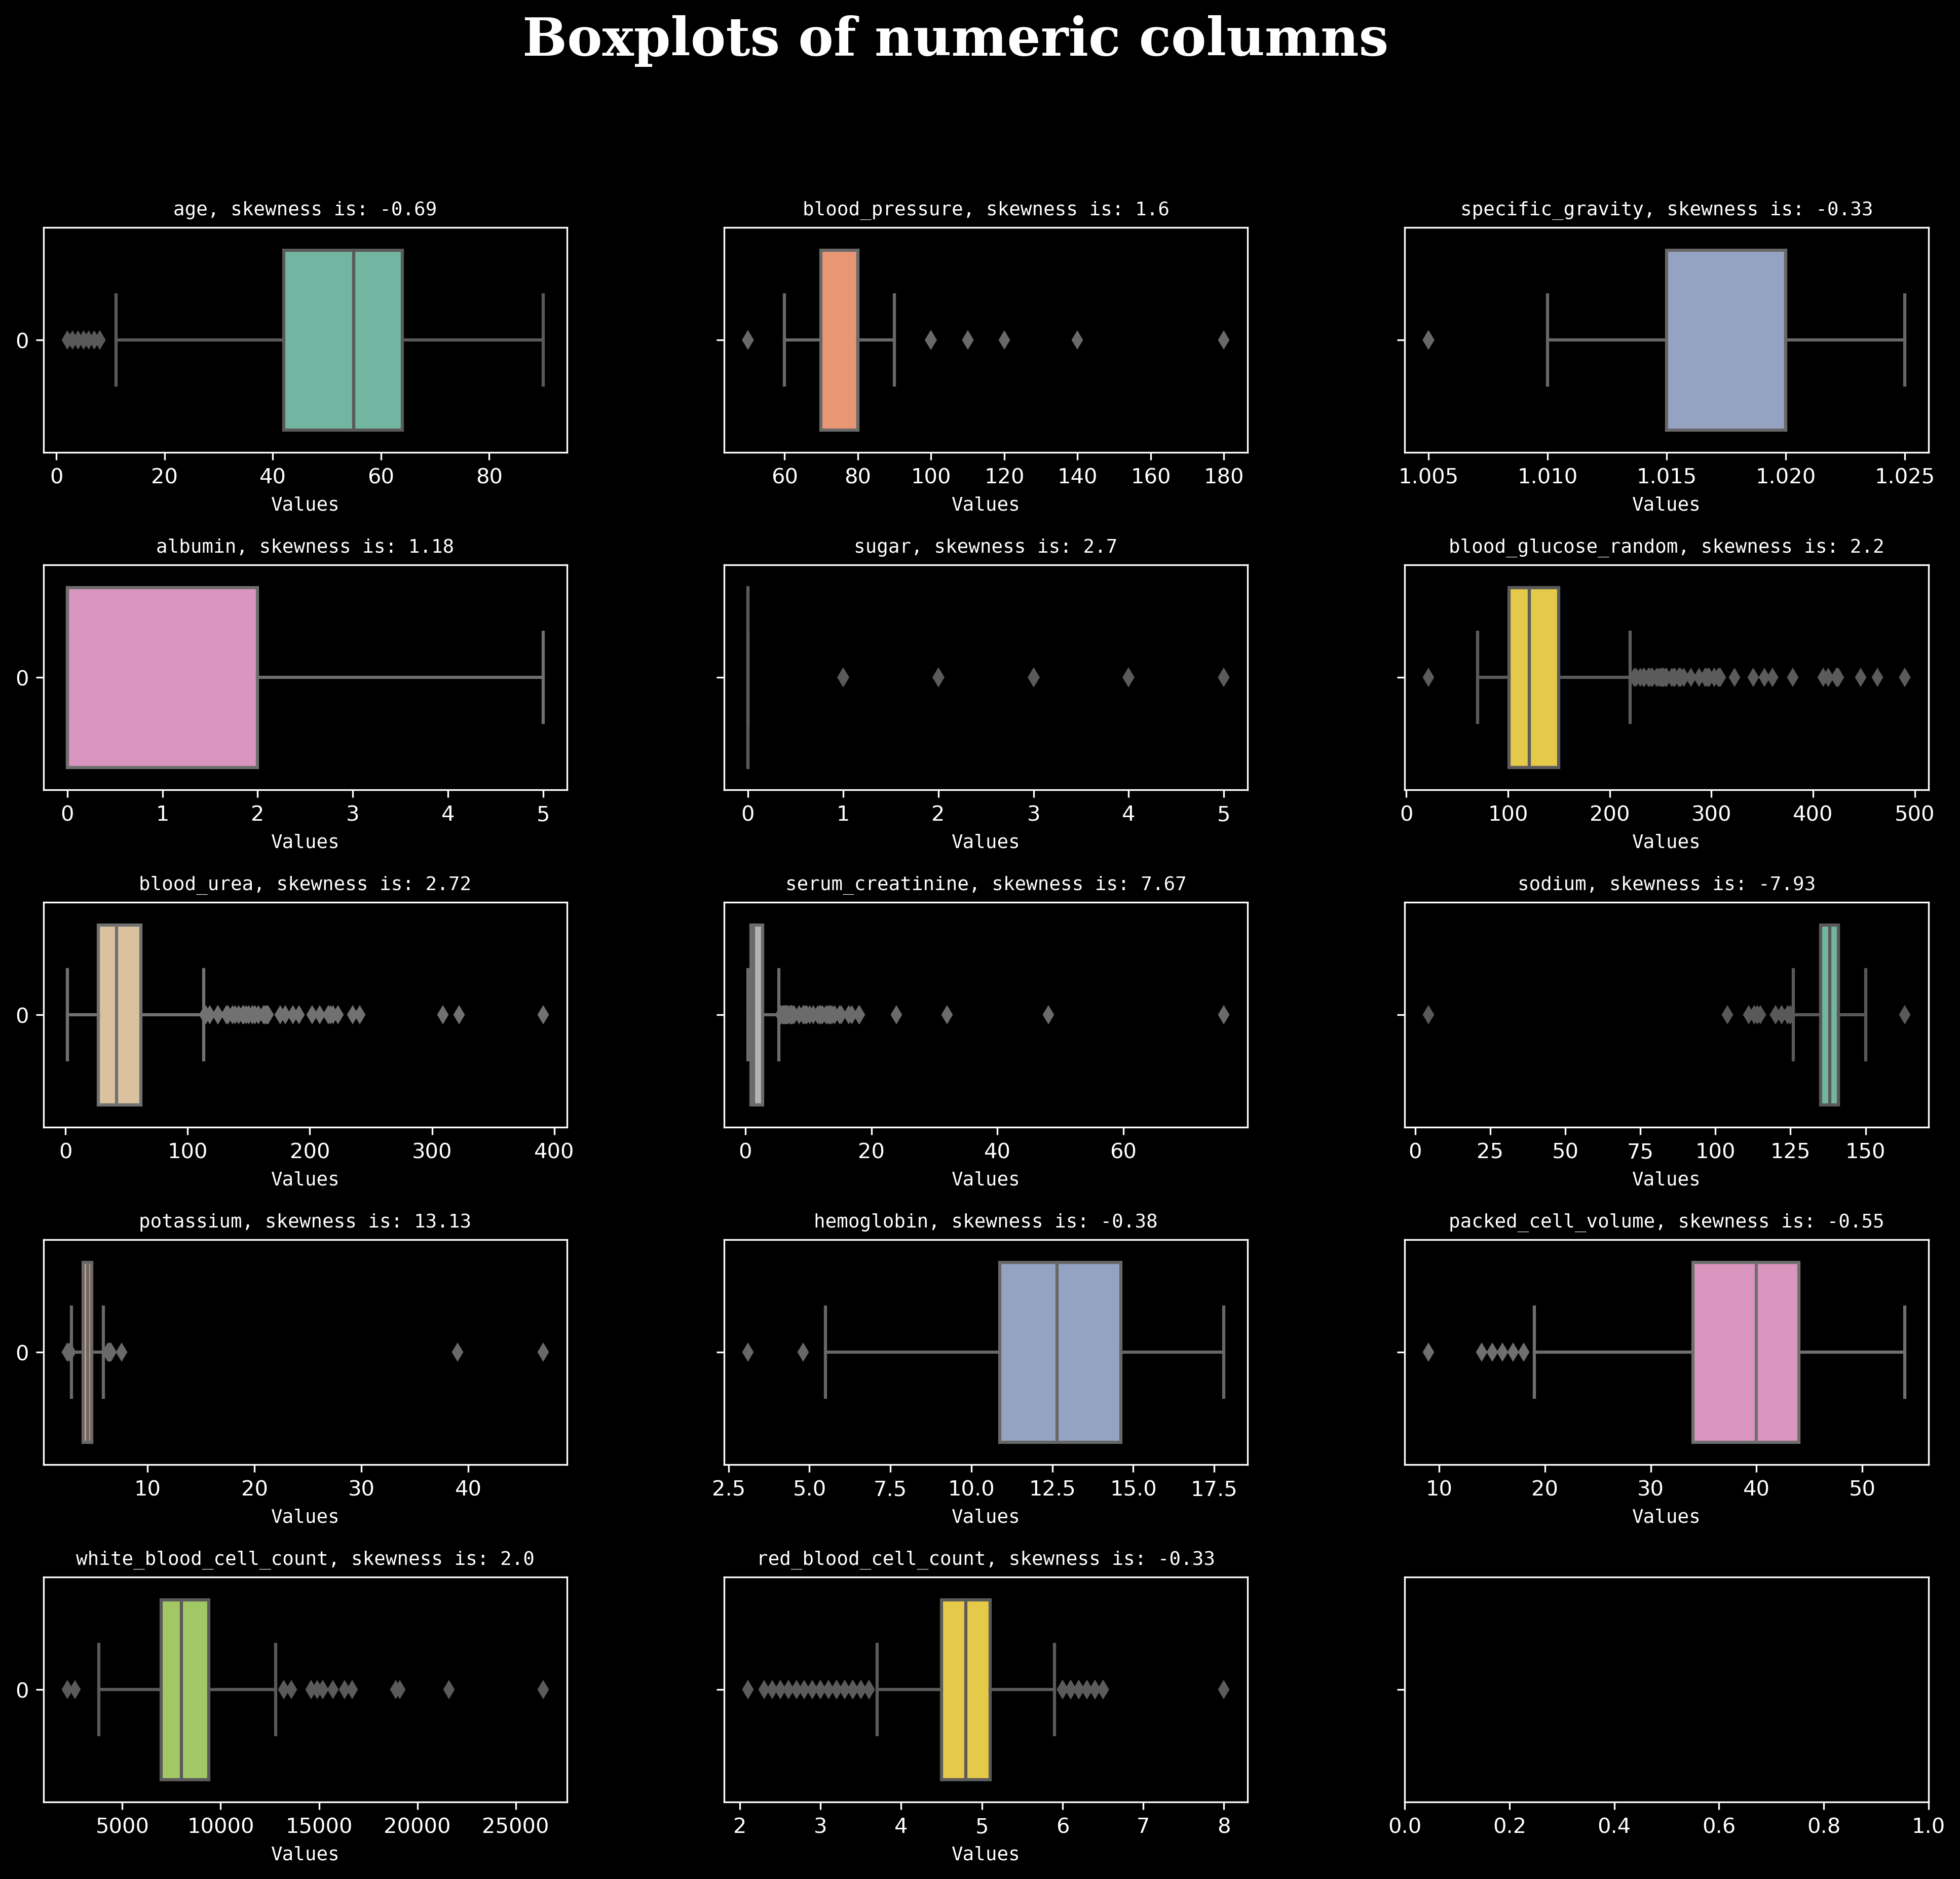

In [29]:
boxplots_custom(df_raw, numeric_cols, 5, 3, 'Boxplots of numeric columns')

# NOTE:
#------
# There is no need to do the same for the categorical columns, because the plots won't be informative.

> Through visual inspection of the resulting boxplots, we can identify **potential outliers** that may require further investigation to determine if they represent valid data or erroneous values. 

--------
**kernel density estimate (KDE)**

In [30]:
def plot_kde_by_class(df, column, class_column='class', figsize=(12, 6)):
	"""
	Plot kernel density estimates (KDE) of a given column in a pandas DataFrame, grouped by a categorical variable.

	Parameters
	----------
	df : pandas DataFrame
		The DataFrame to use for plotting.
	column : str
		The name of the column to plot.
	class_column : str, optional (default='class')
		The name of the categorical column to group the data by.
	figsize : tuple, optional (default=(12, 6))
		The size of the resulting plot.

	Returns
	-------
	matplotlib.axes.Axes
		The resulting plot.

	"""
	# Create a FacetGrid with KDE plot for each class
	g = sns.FacetGrid(df, hue=class_column, height=figsize[1], aspect=figsize[0]/figsize[1])
	g.map(sns.kdeplot, column)
	g.add_legend()

	# Set plot title and axis labels
	plt.title(f"Kernel Density Estimate for {column} by {class_column}")
	plt.xlabel(column)
	plt.ylabel("Density")

	return g.axes[0]

array([<Axes: title={'center': 'Kernel Density Estimate for specific_gravity by class'}, xlabel='specific_gravity', ylabel='Density'>],
      dtype=object)

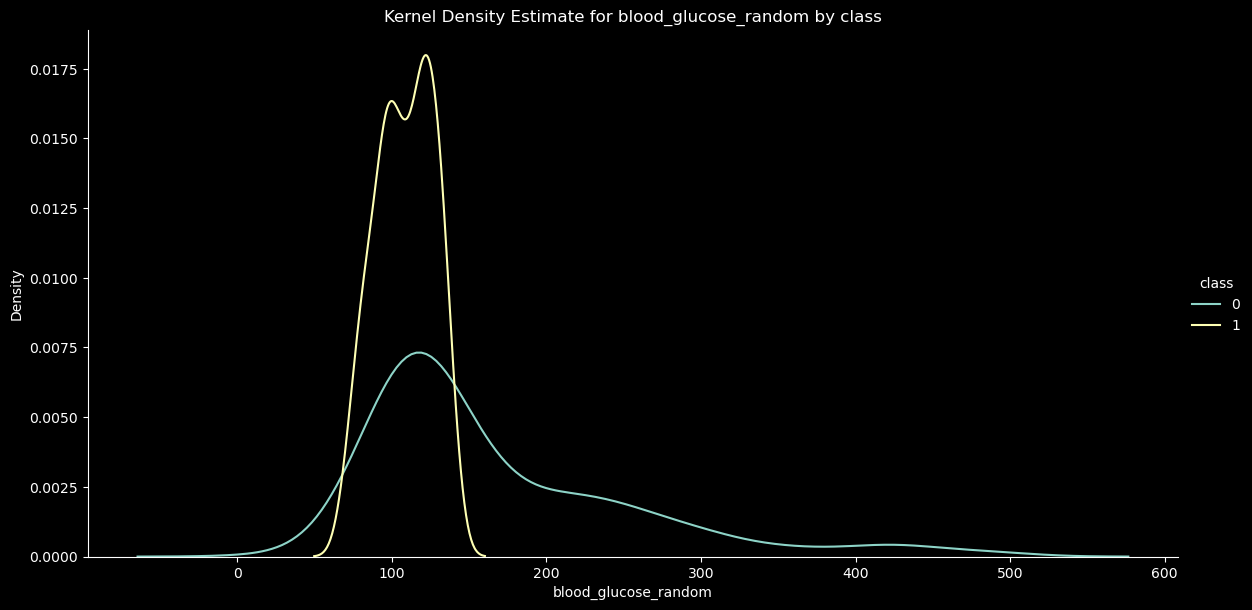

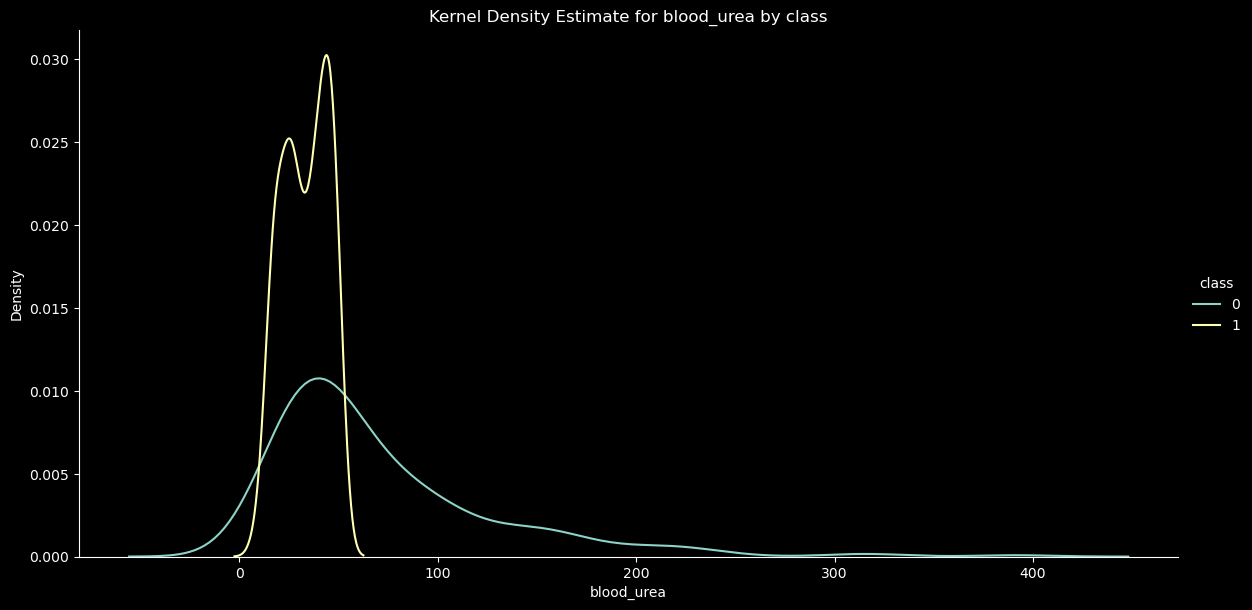

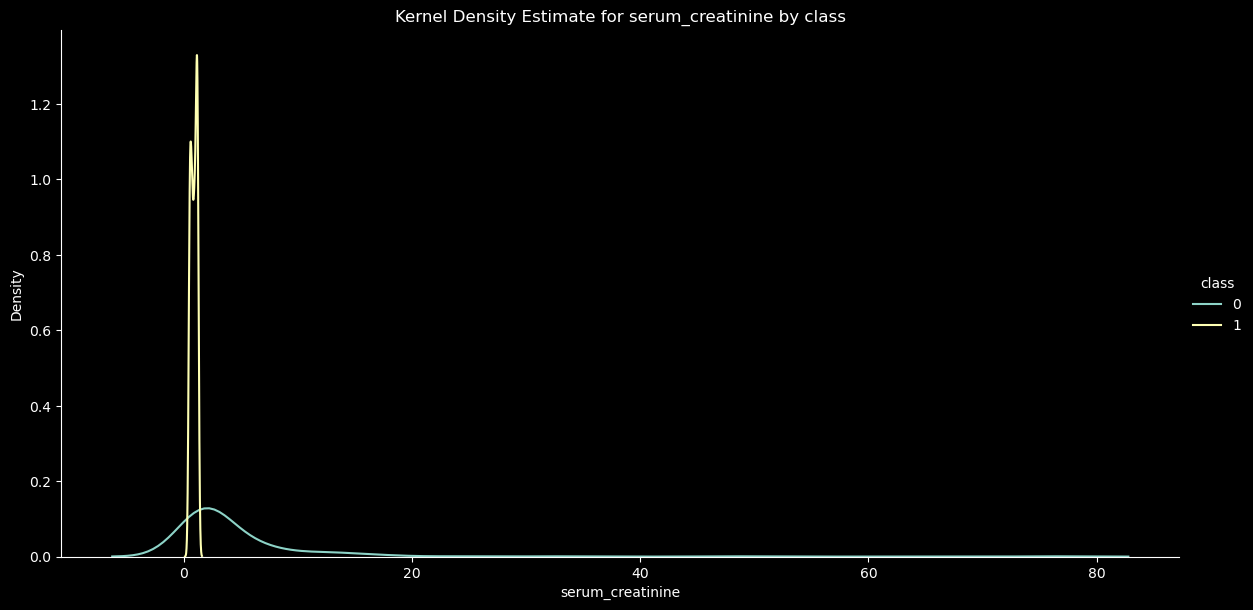

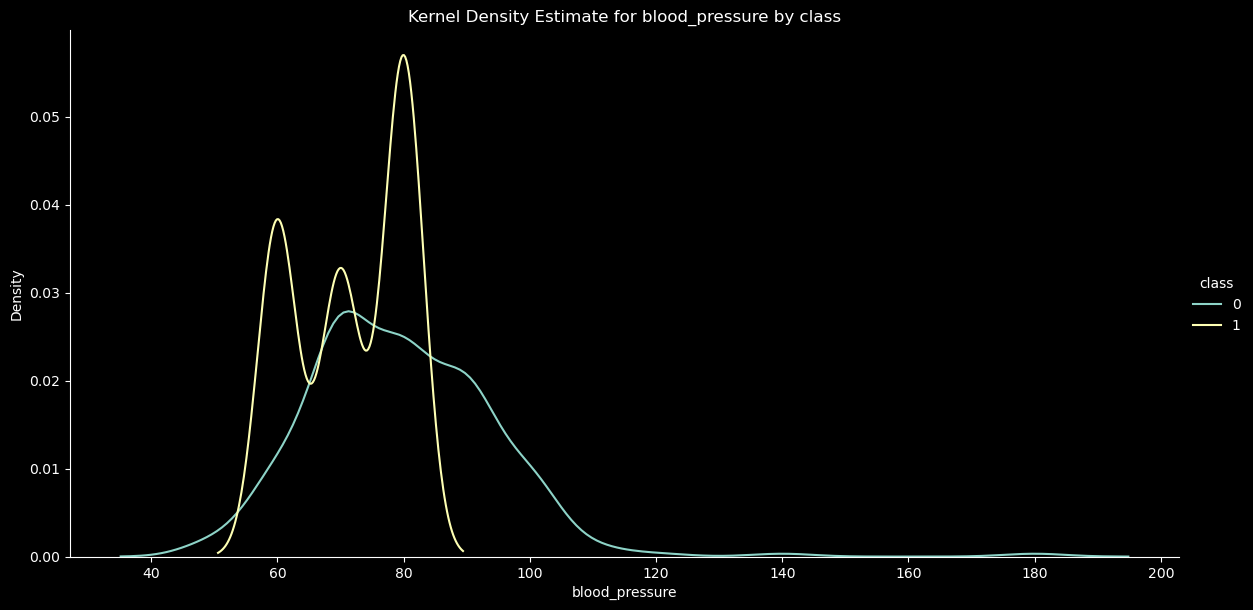

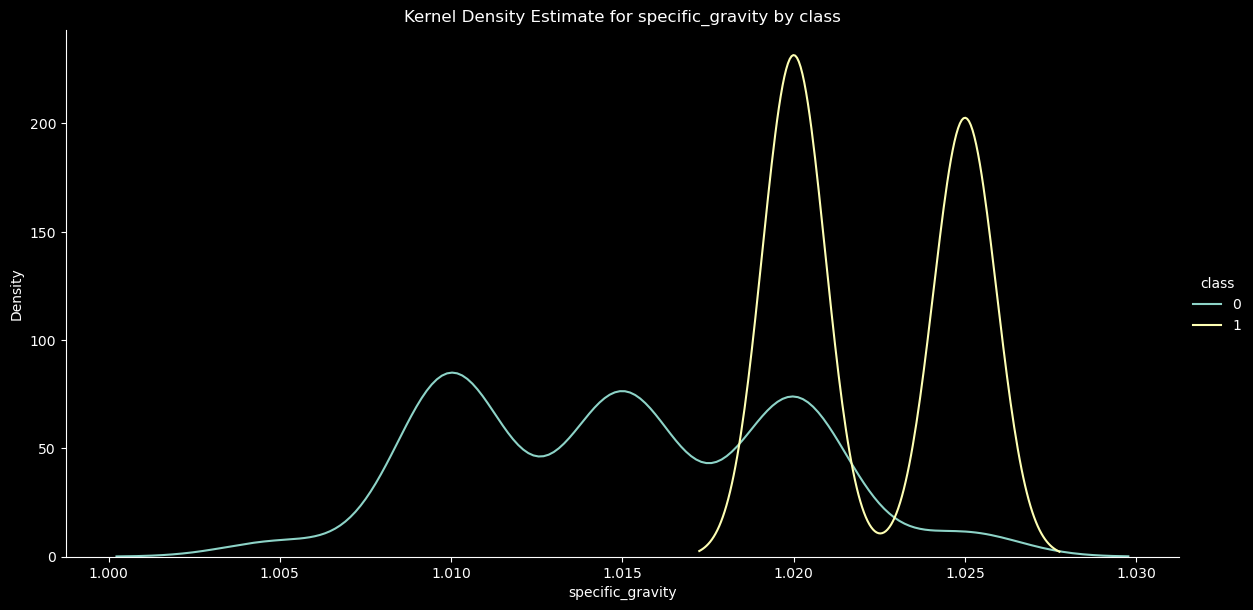

In [31]:
plot_kde_by_class(df_raw, 'blood_glucose_random'),
plot_kde_by_class(df_raw, 'blood_urea'),
plot_kde_by_class(df_raw, 'serum_creatinine'),
plot_kde_by_class(df_raw, 'blood_pressure'),
plot_kde_by_class(df_raw, 'specific_gravity')

> Based on the generated Kernel Density Estimation (KDE) plots, we can observe that the following variables: 'blood_glucose_random'
	'blood_urea', 'serum_creatinine', 'blood_pressure', and 'specific_gravity' show different distribution patterns between patients who have Chronic Kidney Disease (CKD) and those who do not.

> For instance, the KDE plot for 'blood_glucose_random' indicates that patients with CKD tend to have higher levels of blood glucose
	compared to those without CKD. Similarly, the plots for 'blood_urea', 'serum_creatinine', and 'blood_pressure' show that patients with CKD have higher levels of these variables. On the other hand, the KDE plot for 'specific_gravity' suggests that patients without CKD have a higher concentration of this variable in their urine.

Overall, these findings suggest that the variables 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'blood_pressure', and 'specific_gravity' may be important predictors for the occurrence of CKD. However, further investigation is required to determine the statistical significance and the strength of the association between these variables and the development of CKD.

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="5"></a>
			Fix Outliers
</p>

In [32]:
# To detect and (replace or drop) the outlier in the numerical columns.

# The function below takes in a dataframe 'df', a list of column names 'columns', as well as a method 'method' which can either be 'drop' or 'replace'
def drop_replace_outliers(df, columns, method='drop'):
	
	# Loop through each column in the list of column names passed in 
	for col in columns:
		
		# Check for columns that are numeric, i.e. not an object data type
		if df[col].dtype != object: 
		
			# Calculate the first, second and third quartiles and interquartile range (IQR)
			Q1 = df[col].quantile(0.25)
			Q3 = df[col].quantile(0.75)
			IQR = Q3 - Q1
			
			# Calculate upper and lower bounds for identifying outliers
			upper_bound = Q3 + 1.5*IQR
			lower_bound = Q1 - 1.5*IQR
			
			# If method is set to "drop", remove any rows where values fall outside of acceptable range
			if (method == "drop"):
				df = df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]
				
			# If method is set to "replace", replace outlier values with the upper or lower bound
			elif (method == 'replace'):
				df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
				df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
	
	# Return modified dataframe (either with outlier values dropped or replaced)
	return df


In [33]:
# Drop or replace outliers:

df_raw = drop_replace_outliers(df_raw, numeric_cols, method='replace')

**We noticed previously from the Box plot that there were many outliers in the numerical columns, So now after we replaced all the outliers from those columns, let us check again if there still any outlier using Box Plot again.**

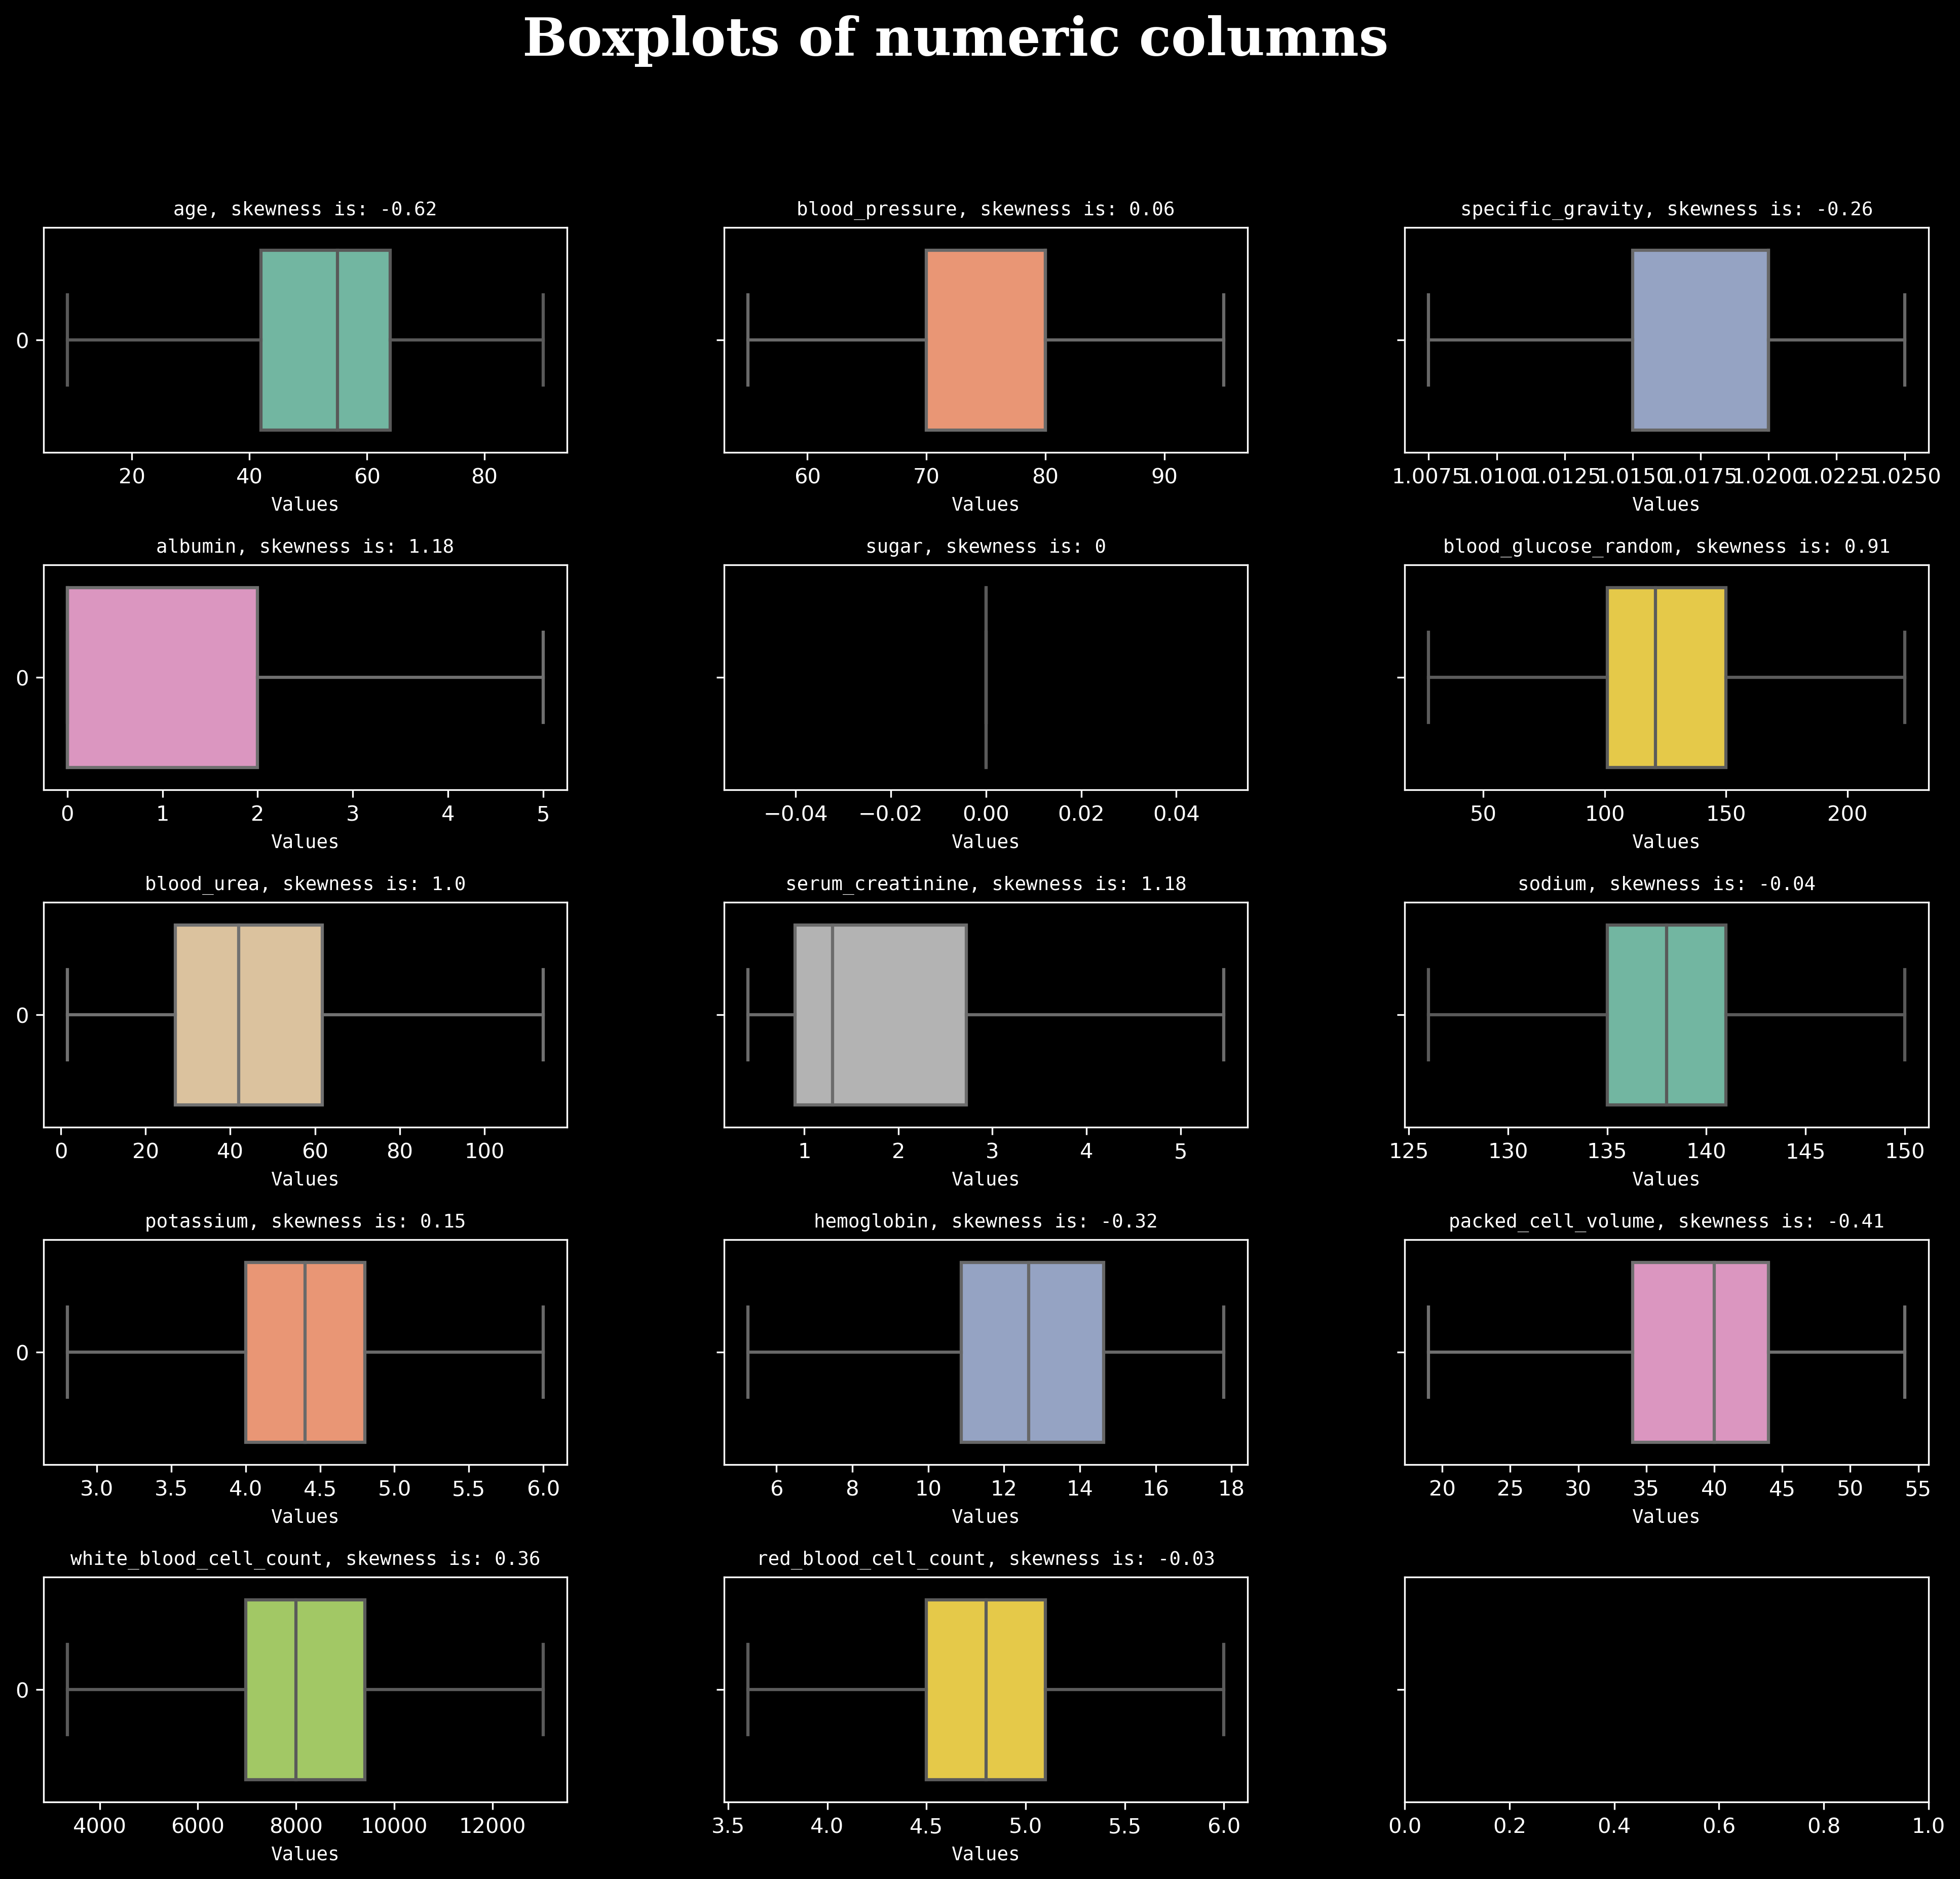

In [34]:
boxplots_custom(df_raw, numeric_cols, 5, 3, 'Boxplots of numeric columns')

**From the previous we notice that we have fixed all the outliers in the numeric columns.**

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="6"></a>
			Split the [train/test] data
</p>


In [35]:
# ---------------------------------------------------------------------------------------------------------------------------
# Splitting the dataset into two parts:
# 
## y = df["class"]: 
#---------------------
# Creating a new variable y and assigning it the values of the target column from the df dataset. 
# The target column is assumed to be the response variable or the dependent variable that the model will predict.
# 
## X=df.drop('class',axis=1): 
#-----------------------------
# Creating a new variable X and assigning it all columns of the df_raw data_frame except the 'class column.
# The X variable is assumed to be the feature variable or the independent variable that the model will use to 
# predict the target column.
# ---------------------------------------------------------------------------------------------------------------------------
## NOTE:
## ------
## In supervised learning, the model learns to predict the response variable (y) based on the input features (X).
## Therefore, the response variable is separated from the input features, so that the model can be trained on 
## the input features and their corresponding response variables.
# ---------------------------------------------------------------------------------------------------------------------------

X = df_raw.drop('class', axis=1)
y = df_raw['class']

In [36]:
X.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,anemia
0,48.0,80.0,1.0200,1.0,0.0,0.0,0.0,0.0,0.0,121.0,...,15.4,44.0,7800.0,5.2,1.0,1.0,0.0,0.0,0.0,0.0
1,9.0,55.0,1.0200,4.0,0.0,0.0,0.0,0.0,0.0,121.0,...,11.3,38.0,6000.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0
2,62.0,80.0,1.0100,2.0,0.0,0.0,0.0,0.0,0.0,223.5,...,9.6,31.0,7500.0,4.8,0.0,1.0,0.0,1.0,0.0,1.0
3,48.0,70.0,1.0075,4.0,0.0,0.0,1.0,1.0,0.0,117.0,...,11.2,32.0,6700.0,3.9,1.0,0.0,0.0,1.0,1.0,1.0
4,51.0,80.0,1.0100,2.0,0.0,0.0,0.0,0.0,0.0,106.0,...,11.6,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64

**Split the Dataframe into training and testing sets:**

> X: is the input feature matrix (independent variables)

> y: is the output target vector (dependent variable) that we want to predict.

> train_test_split(): is a function from the sklearn.model_selection module that randomly splits the data into 
						training and testing subsets.

> test_size: specifies the proportion of the dataset to include in the test set, which is set to 0.2 or 20% in this case.

> random_state: sets the seed for the random number generator used for the data splitting process, 
					ensuring reproducibility of the results.

The output of this function are four datasets: X_train, X_test, y_train, and y_test. 
- X_train and y_train are used to train the machine learning model.
- X_test and y_test are used to evaluate its performance on unseen data.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y)

**Before applying algorithm we should check whether the data is equally splitted or not, because if data is not splitted equally it will cause for data imbalacing problem**

In [39]:
# shape -> (rows, columns)

X_train.shape, X_test.shape

((320, 24), (80, 24))

In [40]:
Counter(y_train)

Counter({0: 200, 1: 120})

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="7"></a>
			Modeling
</p>

<p style = "font-size : 30px; 
			font-family : 'Georgia'; ">
			<a id="7_1"></a>
			1. Decision Tree.
</p>

In [41]:
# Scaling (X_train) and (X_test):
# --------------------------------
# Make sure that all the features are on a similar scale and prevent some features from dominating others.
# This can lead to better performance of machine learning models.
# 
# NOTE:
# -----
# Scaling the target variable (y_train and y_test) is not necessary in most cases,
# because the 'class' variable is typically not used in the same way as the feature variables.
#-----------------------------------------------------------------------------------------------------------------

# scaler = StandardScaler()

# x_train = scaler.fit_transform(X_train)
# x_test = scaler.fit_transform(X_test)

In [42]:
# Visualize a decision tree model using the export_graphviz function from the sklearn.tree module and 
# the pydotplus library to generate the graph.

# [dt_tree]: -> is the trained decision tree model
# [out_file]: -> set to dot_data which is a StringIO object that is used to store the graph in 
#				DOT format (a plain text graph description language).
# [filled] && [rounded]: -> set to True to create a more visually appealing graph with colored nodes and 
#				rounded corners.
# [feature_names]: -> set to x.columns to label the features in the graph.
# [class_names]: -> set to ['No Disease','Disease'] to label the target variable classes in the graph.
# [graph_from_dot_data]: ->  function from pydotplus library is used to create a graph object from the 
#				DOT format data stored in dot_data StringIO object.
# [create_png] method is used to create a PNG image of the graph and display it using the Image function.
#---------------------------------------------------------------------------------------------------------

def get_tree_graph(tree):
	dot_data=StringIO()
	export_graphviz(tree, out_file=dot_data, filled=True, rounded=True,
			feature_names=X.columns,
			class_names=['No Kidney Disease','Kidney Disease'])

	graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
	return graph

In [43]:
# custom function that calculates the evaluation metrics for the [train] set and [test] set.

def evaluate_metric(tree):
	## The predicted values for the train dataset
	train_predict = tree.predict(X_train)
	## The predicted values for the test dataset
	test_predict = tree.predict(X_test)

	# calculating the evaluation metrics on the train set.
	print("Train_Set")
	print("============")
	print(f"Training Accuracy of the Classifier is \n [{accuracy_score(y_train, train_predict)*100}%]")
	print("---------------------------------------------------------------")
	print(f"Confusion Matrix Test data : \n {confusion_matrix(y_train, train_predict)}")
	print("---------------------------------------------------------------")
	print(f"Classification Report Test Data: \n {classification_report(y_train, train_predict)}")
	print("===============================================================")

	print()

	# calculating the evaluation metrics on the test set.
	print("Test_Set")
	print("============")
	print(f"Test Accuracy of the Classifier is \n [{accuracy_score(y_test, test_predict)*100}%]")
	print("---------------------------------------------------------------")
	print(f"Confusion Matrix Test data : \n {confusion_matrix(y_test, test_predict)}")
	print("---------------------------------------------------------------")
	print(f"Classification Report Test Data: \n {classification_report(y_test, test_predict)}")
	print("===============================================================")

<p style = "font-size : 30px; 
			font-family : 'Georgia'; ">
			--------------------<br>
			Grid Search CV.<br>
			--------------------<br>
</p>

In [44]:
dt_tree = DecisionTreeClassifier(random_state=42)

# Create the parameter grid based on the results of random search 
params={
	"max_depth": [2, 3, 5, 6, 7, 9, 15, 20],
	"min_samples_split": [3, 5, 7, 9, 10],
	"min_samples_leaf": [3, 4, 5, 7, 8, 10],
	'criterion':["gini","entropy"],
	'max_features' : ['auto', 'sqrt', 'log2']
}

In [45]:
# [estimator]: -> This parameter takes the machine learning model you want to train and tune, 
#					in this case, dt_hrt_data, which is a decision tree classifier.

# [param_grid]: -> This parameter is a dictionary containing the hyperparameter that will be
#					tuned during the grid search. In this case, the params dictionary is used, which contains different values for max_depth, min_samples_leaf, and criterion hyperparameters.

# [cv]: -> This parameter is an integer or a cross-validation object. In this case, cv=10 means
#			that 4-fold cross-validation will be performed.

# [n_jobs]: -> This parameter is the number of CPU cores to use for parallelizing the grid 
#				search. In this case, n_jobs=-1 means that all available CPU cores will be used.

# [verbose]: -> This parameter controls the verbosity of the output during the grid search. 
#				In this case, verbose=1 means that progress messages will be printed to 
#				the console.

# [scoring]: -> This parameter is used to specify the metric for evaluating the model's 
#				performance. In this case, "accuracy" is used as the scoring metric. 
#				The accuracy measures the proportion of correctly classified instances out 
#				of all instances.

kf = KFold(n_splits=6, shuffle=False)
f1 = make_scorer(f1_score , average='macro')
grid_search=GridSearchCV(estimator=dt_tree,
						param_grid=params,
						cv=kf,n_jobs=-1,verbose=1,scoring="f1")

In [46]:
%%time
grid_search.fit(X_train,y_train)

Fitting 6 folds for each of 1440 candidates, totalling 8640 fits
CPU times: user 1.42 s, sys: 182 ms, total: 1.6 s
Wall time: 5.21 s


GridSearchCV(cv=KFold(n_splits=6, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 6, 7, 9, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [3, 4, 5, 7, 8, 10],
                         'min_samples_split': [3, 5, 7, 9, 10]},
             scoring='f1', verbose=1)

In [47]:
#Creates a pandas DataFrame from the cross-validation results of the grid search object 'grid_search'.
score_df = pd.DataFrame(grid_search.cv_results_)
 
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002471,0.000392,0.001545,0.000190,gini,2,auto,3,3,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.962963,0.9375,0.956522,0.976744,0.9375,0.914286,0.947586,0.020326,46
1,0.001792,0.000348,0.001214,0.000121,gini,2,auto,3,5,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.962963,0.9375,0.956522,0.976744,0.9375,0.914286,0.947586,0.020326,46
2,0.001860,0.000512,0.001636,0.000865,gini,2,auto,3,7,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.962963,0.9375,0.956522,0.976744,0.9375,0.914286,0.947586,0.020326,46
3,0.001777,0.000420,0.001431,0.000591,gini,2,auto,3,9,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.962963,0.9375,0.956522,0.976744,0.9375,0.914286,0.947586,0.020326,46
4,0.001625,0.000319,0.001118,0.000073,gini,2,auto,3,10,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...",0.962963,0.9375,0.956522,0.976744,0.9375,0.914286,0.947586,0.020326,46


In [48]:
# returns the model that had the best performance in terms of mean cross-validated score, 
# as determined by the GridSearchCV function in scikit-learn.

grid_search.best_estimator_

DecisionTreeClassifier(max_depth=6, max_features='auto', min_samples_leaf=3,
                       min_samples_split=3, random_state=42)

In [49]:
dt_best =grid_search.best_estimator_
evaluate_metric(dt_best)

Train_Set
Training Accuracy of the Classifier is 
 [98.75%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[198   2]
 [  2 118]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       200
           1       0.98      0.98      0.98       120

    accuracy                           0.99       320
   macro avg       0.99      0.99      0.99       320
weighted avg       0.99      0.99      0.99       320


Test_Set
Test Accuracy of the Classifier is 
 [96.25%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[49  1]
 [ 2 28]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1      

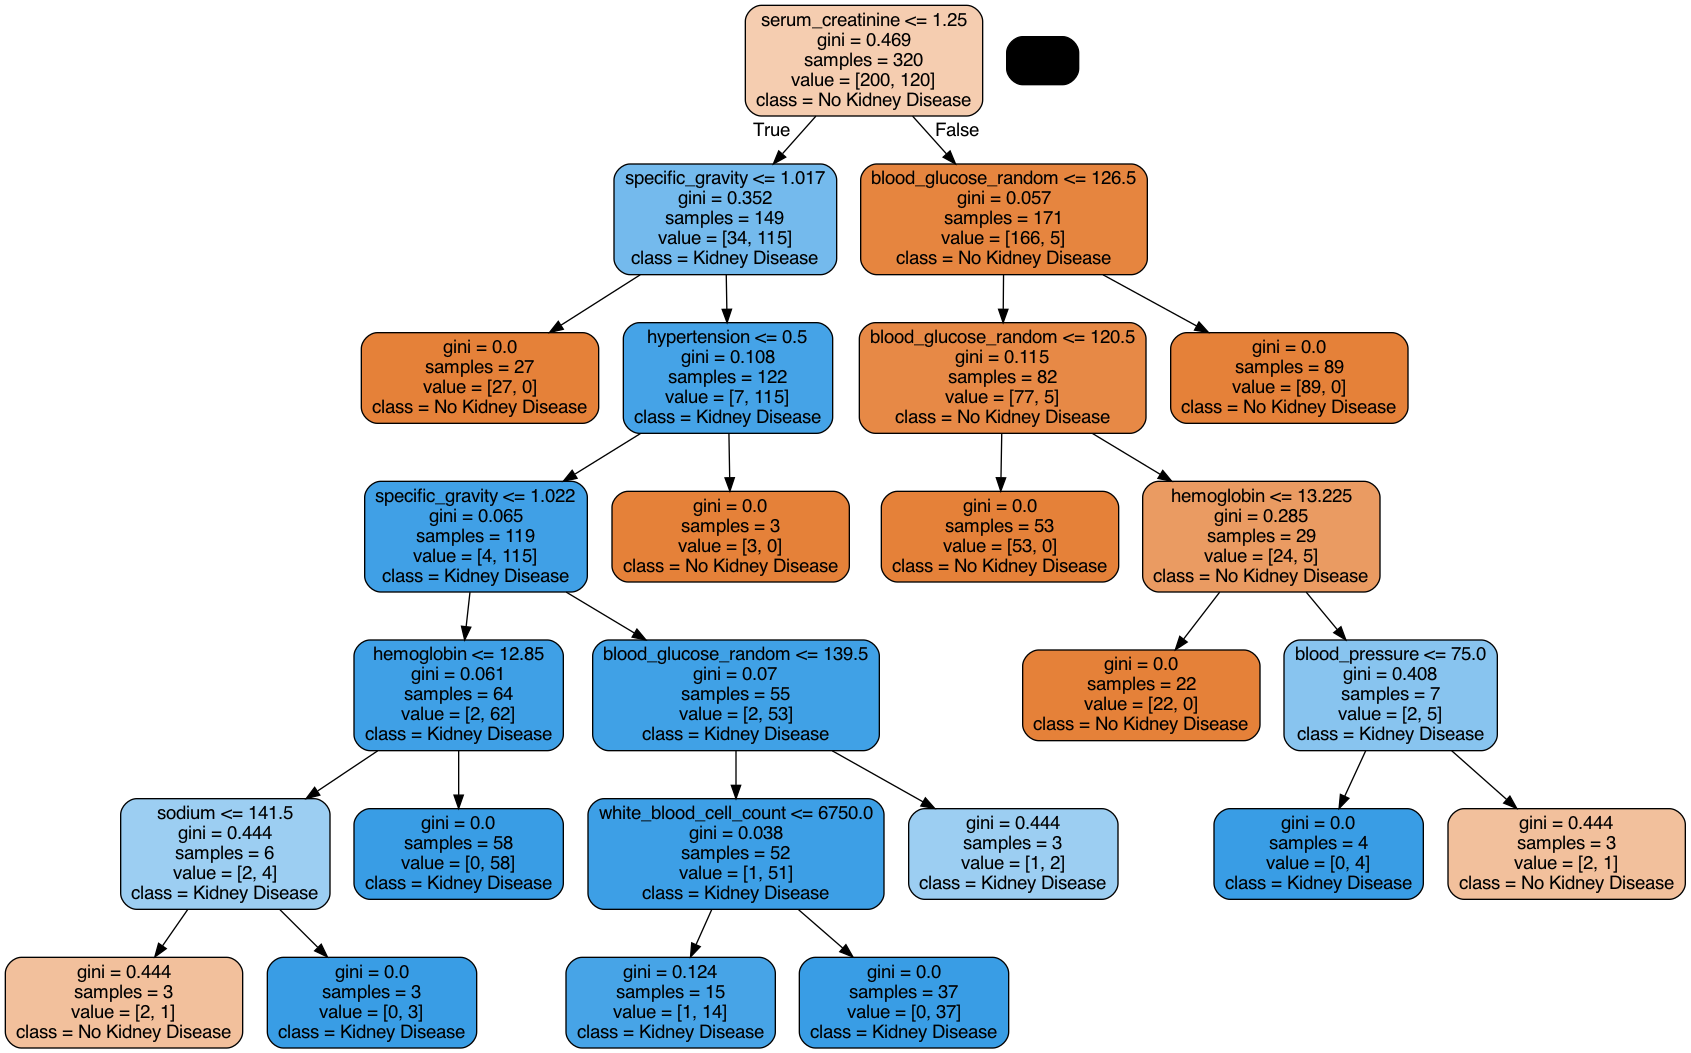

In [50]:
Image(get_tree_graph(dt_best).create_png())

<p style = "font-size : 30px; 
			font-family : 'Georgia'; ">
			<a id="7_2"></a>
			2. Logistic Regression.
</p>

In [51]:
#initializing a logistic regression model
lgr = LogisticRegression(solver= 'liblinear',random_state=0)

In [52]:
# Create the parameter grid for logistic regression
# [c]: -> The parameter controls the penality strength.

params={'C':[0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]} 

In [53]:
# Tuning Hyperparameters using GridSearchCV 
grid_search_lgr=GridSearchCV(estimator=lgr,
						param_grid=params,
						cv=10,n_jobs=-1,verbose=1,scoring="f1")

In [54]:
%%time
grid_search_lgr.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
CPU times: user 64.2 ms, sys: 12.2 ms, total: 76.4 ms
Wall time: 94.5 ms


GridSearchCV(cv=10,
             estimator=LogisticRegression(random_state=0, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0]},
             scoring='f1', verbose=1)

In [55]:
print(f"\nThe best Logistic regression model gives a score of {grid_search_lgr.best_score_}\n")
lgr_best = grid_search_lgr.best_estimator_
lgr_best


The best Logistic regression model gives a score of 0.9641675956893347



LogisticRegression(C=10.0, random_state=0, solver='liblinear')

In [56]:
lgr_best =grid_search_lgr.best_estimator_
evaluate_metric(lgr_best)

Train_Set
Training Accuracy of the Classifier is 
 [98.125%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[196   4]
 [  2 118]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       200
           1       0.97      0.98      0.98       120

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320


Test_Set
Test Accuracy of the Classifier is 
 [98.75%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[50  0]
 [ 1 29]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1     

<p style = "font-size : 30px; 
			font-family : 'Georgia'; ">
			<a id="7_3"></a>
			3. Random Forest.
</p>

In [57]:
#initializing a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [58]:
# Create the parameter grid with random search hyperparameters
# 
# [max_depth]: -> The maximum depth of the tree. If None, then nodes are expanded until all 
#                 leaves are pure or until all leaves contain less than min_samples_split samples.
# 
# [min_samples_leaf']: -> The minimum number of samples required to be at a leaf node.
#                 A split point at any depth will only be considered if it leaves at
#                 least ``min_samples_leaf`` training samples in each of the left and right branches.
# 
# [max_features]: -> The number of features to consider when looking for the best split.
# 
# [n_estimators]: -> The number of trees in the forest.

params = {
    'max_depth': [1, 2, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 50, 100, 200]
}

In [59]:
# Tuning Hyperparameters using GridSearchCV 
grid_search_rf = GridSearchCV(estimator=rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [60]:
grid_search_rf.fit(X_train,y_train)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 5, 10, 20],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [61]:
print(f"The Best Random Forest Classifier gives a score of {grid_search_rf.best_score_}")
rf_best = grid_search_rf.best_estimator_
rf_best

The Best Random Forest Classifier gives a score of 1.0


RandomForestClassifier(max_depth=5, max_features=3, min_samples_leaf=5,
                       n_estimators=10, n_jobs=-1, random_state=42)

In [62]:
evaluate_metric(rf_best)

Train_Set
Training Accuracy of the Classifier is 
 [99.6875%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[200   0]
 [  1 119]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      0.99      1.00       120

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


Test_Set
Test Accuracy of the Classifier is 
 [98.75%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[50  0]
 [ 1 29]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1    

<p style = "font-size : 30px; 
			font-family : 'Georgia'; ">
			<a id="7_4"></a>
			4. XGBoost.
</p>

In [63]:
xgb = XGBClassifier()

In [64]:
# [learning_rate]: -> Boosting learning rate
# [max_depth]: -> Maximum tree depth for base learners
# [min_child_weight]: ->  Minimum sum of instance weight needed in a child.
# [gamma]: -> Minimum loss reduction required to make a further partition on a leaf node of the tree
# [colsample_bytree]: -> Subsample ratio of columns when constructing each tree.

params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth': [ 3, 4, 5, 6, 8],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4] ,
 'colsample_bytree': [ 0.3, 0.5 , 0.8 ]
}

In [65]:
grid_search_xgb = GridSearchCV(estimator=xgb, 
                               param_grid=params, 
                               cv=4, 
                               n_jobs=-1, 
                               verbose=1, 
                               scoring = "f1")

In [66]:
grid_search_xgb.fit(X_train,y_train)

Fitting 4 folds for each of 1800 candidates, totalling 7200 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                         

In [67]:
print(f"The Best XGB Classifier gives a score of {grid_search_xgb.best_score_}")
xgb_best = grid_search_xgb.best_estimator_
xgb_best

The Best XGB Classifier gives a score of 0.9915254237288136


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [68]:
evaluate_metric(xgb_best)

Train_Set
Training Accuracy of the Classifier is 
 [100.0%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[200   0]
 [  0 120]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       120

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320


Test_Set
Test Accuracy of the Classifier is 
 [98.75%]
---------------------------------------------------------------
Confusion Matrix Test data : 
 [[50  0]
 [ 1 29]]
---------------------------------------------------------------
Classification Report Test Data: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1      

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="8"></a>
			Feature Engineering
</p>

In [69]:
def feature_importance_report(model, X_cols, X, figsize=(12, 3)):
	"""
	Returns a report on feature importance for a given model and feature matrix X.

	Parameters:
		model (estimator): A fitted machine learning model with a feature_importances_ attribute.
		X_cols (list): A list of feature names.
		X (DataFrame): A feature matrix.
		figsize (tuple): Figure size in inches (width, height).

	Returns:
		DataFrame: A report on feature importance, sorted in descending order by importance.
	"""
	# Create a DataFrame to store feature importance
	importance_df = pd.DataFrame({'feature': X_cols, 'importance': model.feature_importances_})
	
	# Sort features by importance in place
	importance_df.sort_values('importance', ascending=False, inplace=True)
	
	# Create a plot of feature importance using Seaborn
	plt.figure(figsize=figsize)
	sns.barplot(x='feature', y='importance', data=importance_df)
	plt.xticks(rotation=90)
	plt.title('Feature Importance')
	plt.show()
	
	# Return the report sorted by importance
	return importance_df.sort_values('importance', ascending=False)

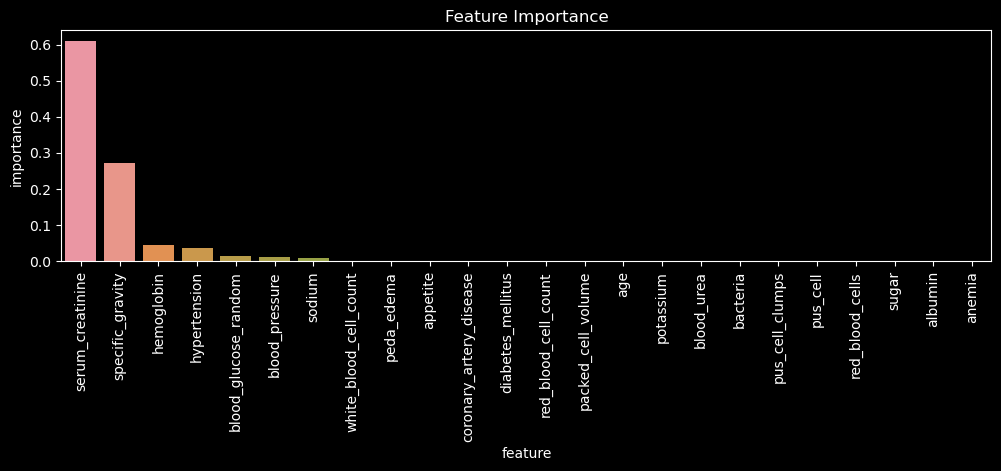

,feature,importance
11,serum_creatinine,0.609222
2,specific_gravity,0.272581
14,hemoglobin,0.045979
18,hypertension,0.037921
9,blood_glucose_random,0.013816
1,blood_pressure,0.010572
12,sodium,0.009251
16,white_blood_cell_count,0.000658
10,blood_urea,0.000000
3,albumin,0.000000


In [70]:
feature_importance_report(dt_best, X_test.columns.tolist(), X_test)

In [71]:
def explain_instance_lime(X_train, X_test, y_train, j, num_features=24):
	"""
	Explains the prediction for a given instance using LIME.

	Parameters:
		X_train (DataFrame): The feature matrix used to train the classifier.
		X_test (DataFrame): The feature matrix used to test the classifier.
		y_train (Series): The target vector used to train the classifier.
		j (int): The index of the instance to explain.
		num_features (int): The number of features to include in the explanation.

	Returns:
		DataFrame: A LIME explanation report, including a table and plot.
	"""
	# Create a LIME explainer object
	explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
													   feature_names=X_test.columns.values.tolist(),
													   class_names=['ckd', 'not ckd'], verbose=True,
													   mode='classification')

	try:
		# Explain the prediction for the selected instance
		exp = explainer.explain_instance(X_train.values[j], dt_best.predict_proba, num_features=num_features)

		# Display the LIME explanation report
		exp.show_in_notebook(show_table=True)
		
		# Return the LIME explanation table as a DataFrame
		return pd.DataFrame(exp.as_list(), columns=['feature', 'weight'])

	except Exception as e:
		print(f"An error occurred while explaining instance {j}: {e}")
		return None

explain_instance_lime(X_train, X_test, y_train, 0, num_features=24)

Intercept 0.3142704727870336
Prediction_local [-0.08712973]
Right: 0.0


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,feature,weight
0,0.00 < hypertension <= 1.00,-0.233991
1,serum_creatinine > 2.70,-0.187261
2,1.01 < specific_gravity <= 1.02,0.126498
3,bacteria <= 0.00,-0.033555
4,hemoglobin <= 10.90,-0.026939
5,red_blood_cells <= 0.00,-0.015998
6,appetite <= 0.00,-0.014306
7,pus_cell_clumps <= 0.00,0.010814
8,sodium <= 135.00,-0.010598
9,peda_edema <= 0.00,-0.010186


<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="9"></a>
			Model Evaluation
</p>

<p style = "font-size : 30px; 
			text-align : center; 
			background-color : #AE9C;
			color : #123 ; 
			font-family : 'Georgia'; 
			border-radius: 20px 20px;">
			<a id="10"></a>
			Conclusion